In [1]:
'''
Visualize pressure measurement of BioTac (For measurements on the back of the finger)
Author: Yitian Shao
Created on 2022.06.15
Updated on 2022.06.22
'''
# %matplotlib notebook 
# %matplotlib notebook 

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

plt.rc('font', size=14, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='0.5', linewidth=0.75)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rcParams.update({'errorbar.capsize': 4})

In [2]:
'''
General Functions
'''

def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def yyAxisPlot(x0, y0, x1, y1, xText=None, y0Text=None, y1Text=None):
    ax0, fig0 = aPlot(); 
    ax0.set_xlabel(xText)
    ax0.plot(x0, y0, color='tab:orange'); 
    ax0.set_ylabel(y0Text, color='tab:orange')
    ax0.tick_params(axis='y', labelcolor='tab:orange')

    ax1 = ax0.twinx()
    ax1.plot(x1, y1, color='tab:blue');
    ax1.set_ylabel(y1Text, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    fig0.tight_layout() 

def sample2Time(ax, Fs): # Covert the xticks of current plot from samples to time using Fs
    locs, _ = plt.xticks()
    plt.xticks(locs, locs/Fs)
    ax.set_xlim(0, locs[-1])
    ax.set_xlabel('Time (secs)')

def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeActuatorInfo(rootName):
    actLabel = re.findall('Act\d+mm\d+\.\d+mL', rootName)
    if actLabel:
        actLabel = actLabel[0]
    return actLabel
    
def decodeDataType(fileName):
    dataType = re.findall('Pdc|Pac', fileName)
    if dataType:
        dataType = dataType[0]
    return dataType

def decodeData(fileName, numFormat, frontCode='', rearCode=''):
    segStr = re.findall(frontCode+numFormat+rearCode, fileName)
    if segStr:
        numData = float(re.findall(numFormat, segStr[0])[0])
    else:
        numData = None
    return numData

def cutRepeatTrial(datain, Fs, expectedTrialNum, disp=False):
    rawData = datain[:,1]
    smData = lowpassSmooth(rawData)
    
    smData = signal.detrend(smData, type='linear')
    
    samp = np.arange(len(rawData))
    
    maxRawValue = np.max(smData)
    
    ''' Fine tunning needed for individual measurement session'''
    segPointInd = np.squeeze(np.argwhere(smData[10:] > 0.25 * maxRawValue))+50 # Find value larger than 25% of peak as valid segment data point
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > 1))# Index of point where large gap occurs (end and start of a seg)
    cutInd = (0.5 * (segPointInd[segGapInd] + segPointInd[segGapInd+1])).astype(int) # Cut in the middle of a end and a start point
    avgSegLen = np.mean(np.diff(cutInd))
    cutInd = np.insert(cutInd, 0, max(cutInd[0]-avgSegLen, 0))
    
    if disp:
        ax0, _ = aPlot(); ax.plot(samp, rawData, color='k'); 
        ax0.plot(samp, smData, color='tab:blue');
        ax0.plot(cutInd, np.zeros(cutInd.shape), '*r')
        plt.show();
    
    if len(cutInd) != expectedTrialNum:
        cutInd = []
    
    return cutInd

def selectConditions(dFrame, condiList):
    indList = []
    for aCondi in condiList:
        indList.extend(dFrame[dFrame['Label'] == aCondi].index)

    return indList

def computeErrorbar(dFrame, indList, colName):
    compValue = np.array(dFrame.loc[indList,colName].tolist())

    meanValue = np.mean(compValue, axis=1)

    stdValue = np.std(compValue, axis=1)

    return meanValue, stdValue

In [3]:
'''
Load, preprocess and segment BioTac data

Ref: https://syntouchinc.com/wp-content/uploads/2020/09/SynTouch-Product-Manual-BioTac-2020-09-23.pdf
'''

biotacFs = {
  "Pac": 2200,
  "Pdc": 100,
} # The sampling frequency of BioTac depends on data type. 

biotacUnit = {
  "Pac": 0.00037,
  "Pdc": 0.0365,
} # The unit conversion of BioTac depends on data type. Pac: 0.00037kPa/bit, Pdc:  0.0365kPa/bit

# measureDataPath = ".\Data2022.06.14"
measureDataPath = ".\Data2022.06"

DCpressure = []
ACpressure = []

''' Data preprocess and segmentation '''
for root, directories, files in walk(measureDataPath):
    for fileName in files:
        actLabel = decodeActuatorInfo(root)
        
        if actLabel:
            tubeLen = decodeData(actLabel, '\d+', rearCode='mm')
            infillVol = decodeData(actLabel, '[\d+\.]*\d+', rearCode='mL')   
        
        dataType = decodeDataType(fileName)  
        
        if dataType:
            vLevel = decodeData(fileName, '\d+', frontCode='v')
            cTime = decodeData(fileName, '\d+', frontCode='c')
            dTime = decodeData(fileName, '\d+', frontCode='d')
            trialNum = decodeData(fileName, '\d+', frontCode='t')
        
#             print("Len=%d, Infill=%.2f, Condi: %s v=%d c=%d d=%d t=%d" % 
#                   (tubeLen, infillVol, dataType, vLevel, cTime, dTime, trialNum))         
            dLabel = "L%03dF%.1fV%03dC%04dD%04d" % (tubeLen, infillVol, vLevel, cTime, dTime)
    
            ''' Read in data '''
            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            Fs = biotacFs[dataType]
            
            inactiveValue = np.mean(np.concatenate((data[:int(0.2*Fs),1], data[-int(2*Fs):,1])))
            
            ''' Unit conversion process suggested by BioTac manual '''
            data[:,1] = data[:,1] - inactiveValue # Remove DC offset
            data[:,1] = data[:,1] * biotacUnit[dataType] # Convert from bit to physical unit (kPa)
            
            if dataType == 'Pdc':
                cutInd = cutRepeatTrial(data, Fs, 4)

                DCpressure.append([dLabel, tubeLen, infillVol, dataType, vLevel, cTime, dTime, 
                                   trialNum, data, cutInd])
            elif dataType == 'Pac':
                ACpressure.append([dLabel, tubeLen, infillVol, dataType, vLevel, cTime, dTime, 
                                   trialNum, data])
                
DCpressure = pd.DataFrame(DCpressure, columns = ['Label', 'TubeLength_mm','Infill_mL','DType',
                 'Voltage_V','ChargeTime_ms','DischargeTime_ms','Trial','Data','CutIndex'])  
ACpressure = pd.DataFrame(ACpressure, columns = ['Label', 'TubeLength_mm','Infill_mL','DType',
                 'Voltage_V','ChargeTime_ms','DischargeTime_ms','Trial','Data']) 

DCpressure.head(10);

In [4]:
'''
Data restructure (grouping segmented measurements) for analysis and visualization
'''

dictData = {} # Use dictionary to avoid dataframe concatenation errors

for i in DCpressure.index:
    dLabel = DCpressure.loc[i, 'Label']
    dcData = DCpressure.loc[i, 'Data']
    cutIndDC = DCpressure.loc[i, 'CutIndex']
    
    ind = ((ACpressure['Label'] == DCpressure.loc[i, 'Label']) & 
        (ACpressure['Trial'] == DCpressure.loc[i, 'Trial']))   
    acData = ACpressure.loc[ind, 'Data'].values[0]
    
    segNum = len(cutIndDC)
    if segNum: # When data can be segmented
        cutIndAC = cutIndDC * int(biotacFs['Pac'] / biotacFs['Pdc']) # Adjust cut index considering difference in sampling frequency
    
        if dLabel not in dictData: # Initialization for a new label
            dictData[dLabel] = DCpressure.loc[i, ['Label', 'TubeLength_mm','Infill_mL',
                     'Voltage_V','ChargeTime_ms','DischargeTime_ms']]
        
        if 'Pdc' not in dictData[dLabel]: # Initialization for a new column of current label
            dictData[dLabel]['Pdc'] = []
            
        if 'Pac' not in dictData[dLabel]: # Initialization for a new column of current label
            dictData[dLabel]['Pac'] = []
        
        for j in range(segNum):
            if j < segNum-1:
                segDC = dcData[cutIndDC[j]:cutIndDC[j+1],:]
                segAC = acData[cutIndAC[j]:cutIndAC[j+1],:]
            else:
                segDC = dcData[cutIndDC[j]:,:]
                segAC = acData[cutIndAC[j]:,:]

            dictData[dLabel]['Pdc'].append(segDC)  
            dictData[dLabel]['Pac'].append(segAC) 
            
#             yyAxisPlot(segDC[:,0], segDC[:,1], segAC[:,0], segAC[:,1], 
#                        xText=("%s  Time (s)" % dLabel), 
#                        y0Text='DC pressure (kPa)', y1Text='AC pressure (kPa)')
#             plt.show();
    else:
        print("[Warining] Data cannot be segmented: %s" % dLabel)
        
        
''' Convert the disctionary to a dataframe '''
allData = None

for dLabel in dictData:
    aFrame = dictData[dLabel].to_frame().T   
    
    if allData is None:
        allData = aFrame
    else:
        allData = pd.concat([allData, aFrame], axis=0)
    
display(allData)    

[Warining] Data cannot be segmented: L110F1.5V001C0400D4000


,Label,TubeLength_mm,Infill_mL,Voltage_V,ChargeTime_ms,DischargeTime_ms,Pdc,Pac
0,L110F1.5V100C0400D4000,110,1.5,100,400,4000,"[[[0.44886, -0.02372500000000332], [0.45886, -...","[[[0.44, 9.028305785122257e-05], [0.44045, 0.0..."
1,L110F1.5V015C0400D4000,110,1.5,15,400,4000,"[[[0.20886, -0.06321136363636423], [0.21886, -...","[[[0.2, 0.0008097190082644988], [0.20045, 0.00..."
3,L110F1.5V025C0400D4000,110,1.5,25,400,4000,"[[[0.42886, 0.013272727272731799], [0.43886, 0...","[[[0.42, 0.0011970723140496261], [0.42045, 0.0..."
4,L110F1.5V002C0400D4000,110,1.5,2,400,4000,"[[[0.38886, 0.00398181818181456], [0.39886, 0....","[[[0.38, -0.0013209917355371818], [0.38045, -0..."
5,L110F1.5V035C0400D4000,110,1.5,35,400,4000,"[[[1.0789, -0.015595454545456959], [1.0889, 0....","[[[1.07, 0.0012059400826446517], [1.0705, 9.59..."
6,L110F1.5V050C0400D4000,110,1.5,50,400,4000,"[[[0.59886, -0.00763181818181124], [0.60886, -...","[[[0.59, -0.0010577871900826652], [0.59045, -0..."
7,L110F1.5V005C0400D4000,110,1.5,5,400,4000,"[[[0.57886, -0.03002954545454304], [0.58886, -...","[[[0.57, -0.0009684979338842617], [0.57045, -0..."
8,L110F1.5V075C0400D4000,110,1.5,75,400,4000,"[[[0.44886, -0.038822727272725156], [0.45886, ...","[[[0.44, -0.0009749194214876229], [0.44045, -0..."


In [5]:
'''Feature extraction from signals: peak value, time-averaged value, rising time'''

column_peakDC = []
column_tavgDC = []
column_triseDC = []

for _, aRow in allData.iterrows():
    print(aRow['Label'])
#     print(\"Len=%d, Infill=%.2f, Condi: v=%d c=%d d=%d\" % (aRow['TubeLength_mm'], aRow['Infill_mL'], aRow['Voltage_V'],
#                    aRow['ChargeTime_ms'], aRow['DischargeTime_ms'])) 
    peakDC = []
    tavgDC = []
    triseDC = []
    
    for aSignal in aRow['Pdc']:
        smData = lowpassSmooth(aSignal[:,1])
        smData = signal.detrend(smData, type='linear')
   
        maxValue = np.max(smData)
        onsetInd = np.argwhere(smData[50:] > 0.25 * maxValue)[0][0]+50
       
        peakInd = np.argmax(smData)
        peakValue = np.max(aSignal[:,1])
  
        riseTime = aSignal[peakInd,0] - aSignal[onsetInd,0]
        tavgValue = np.mean(aSignal[onsetInd:peakInd,1])
        
        peakDC.append(peakValue)
        tavgDC.append(tavgValue)
        triseDC.append(riseTime)
      
#         ax1,_ = aPlot()
#         ax1.plot(aSignal[:,0], aSignal[:,1], 'k')
#         ax1.plot(aSignal[:,0], smData, 'g')
#         ax1.plot([aSignal[onsetInd,0], aSignal[onsetInd,0]], [0, maxValue], '-r')
#         ax1.plot([aSignal[peakInd,0], aSignal[peakInd,0]], [0, maxValue], '-r')
#         ax1.set_xlabel(\"peak=%.1fkPa - tAvg=%.1fkPa - riseT=%.3fs\" % (peakValue,tavgValue,riseTime))
#         plt.show()
    
    column_peakDC.append(peakDC)
    column_tavgDC.append(tavgDC)
    column_triseDC.append(triseDC)
    
allData['PeakPdc'] = column_peakDC
allData['AvgPdc'] = column_tavgDC
allData['TrisePdc'] = column_triseDC

display(allData)

L110F1.5V100C0400D4000
L110F1.5V015C0400D4000
L110F1.5V025C0400D4000
L110F1.5V002C0400D4000
L110F1.5V035C0400D4000
L110F1.5V050C0400D4000
L110F1.5V005C0400D4000
L110F1.5V075C0400D4000


,Label,TubeLength_mm,Infill_mL,Voltage_V,ChargeTime_ms,DischargeTime_ms,Pdc,Pac,PeakPdc,AvgPdc,TrisePdc
0,L110F1.5V100C0400D4000,110,1.5,100,400,4000,"[[[0.44886, -0.02372500000000332], [0.45886, -...","[[[0.44, 9.028305785122257e-05], [0.44045, 0.0...","[2.3852749999999965, 2.3487749999999967, 2.348...","[1.6384288461538423, 1.5541980769230732, 1.571...","[0.1299999999999999, 0.1299999999999999, 0.130..."
1,L110F1.5V015C0400D4000,110,1.5,15,400,4000,"[[[0.20886, -0.06321136363636423], [0.21886, -...","[[[0.2, 0.0008097190082644988], [0.20045, 0.00...","[1.8712886363636356, 1.7982886363636357, 1.798...","[1.2395578671328666, 1.217096328671328, 1.2538...","[0.13000000000000012, 0.1299999999999999, 0.11..."
3,L110F1.5V025C0400D4000,110,1.5,25,400,4000,"[[[0.42886, 0.013272727272731799], [0.43886, 0...","[[[0.42, 0.0011970723140496261], [0.42045, 0.0...","[2.020772727272732, 2.020772727272732, 2.02077...","[1.321657342657347, 1.38623426573427, 1.386234...","[0.1299999999999999, 0.1299999999999999, 0.130..."
4,L110F1.5V002C0400D4000,110,1.5,2,400,4000,"[[[0.38886, 0.00398181818181456], [0.39886, 0....","[[[0.38, -0.0013209917355371818], [0.38045, -0...","[0.07698181818181456, 0.07698181818181456, 0.0...","[0.051217112299461624, 0.03318181818181456, 0....","[0.17000000000000015, 0.14999999999999947, 0.1..."
5,L110F1.5V035C0400D4000,110,1.5,35,400,4000,"[[[1.0789, -0.015595454545456959], [1.0889, 0....","[[[1.07, 0.0012059400826446517], [1.0705, 9.59...","[2.174404545454543, 2.137904545454543, 2.10140...","[1.4022891608391583, 1.4778628787878763, 1.417...","[0.1299999999999999, 0.1200000000000001, 0.120..."
6,L110F1.5V050C0400D4000,110,1.5,50,400,4000,"[[[0.59886, -0.00763181818181124], [0.60886, -...","[[[0.59, -0.0010577871900826652], [0.59045, -0...","[2.4378681818181884, 2.4378681818181884, 2.364...","[1.7339396103896172, 1.6896181818181886, 1.705...","[0.13999999999999968, 0.14000000000000057, 0.1..."
7,L110F1.5V005C0400D4000,110,1.5,5,400,4000,"[[[0.57886, -0.03002954545454304], [0.58886, -...","[[[0.57, -0.0009684979338842617], [0.57045, -0...","[0.9189704545454569, 0.8459704545454569, 0.845...","[0.6895418831168856, 0.5960858391608415, 0.596...","[0.14000000000000012, 0.1299999999999999, 0.13..."
8,L110F1.5V075C0400D4000,110,1.5,75,400,4000,"[[[0.44886, -0.038822727272725156], [0.45886, ...","[[[0.44, -0.0009749194214876229], [0.44045, -0...","[2.4066772727272747, 2.4066772727272747, 2.370...","[1.626138811188813, 1.676677272727275, 1.63175...","[0.1299999999999999, 0.1299999999999999, 0.129..."


L110F1.5V100C0400D4000
Len=110, Infill=1.50, Condi: v=100 c=400 d=4000


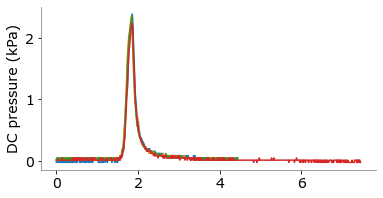

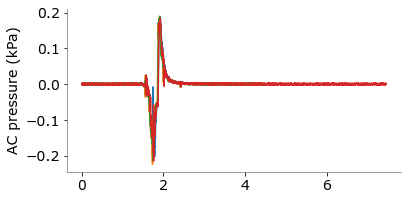

L110F1.5V015C0400D4000
Len=110, Infill=1.50, Condi: v=15 c=400 d=4000


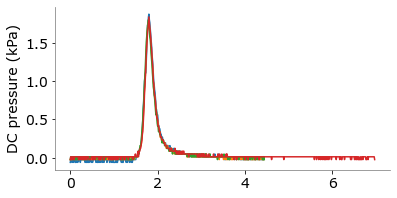

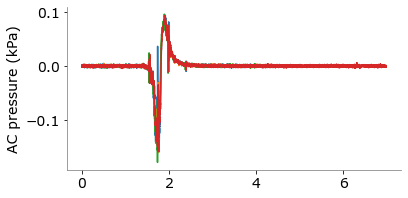

L110F1.5V025C0400D4000
Len=110, Infill=1.50, Condi: v=25 c=400 d=4000


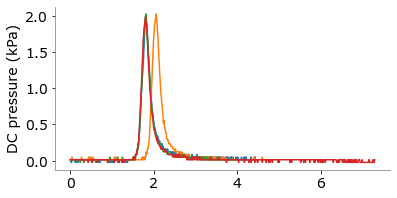

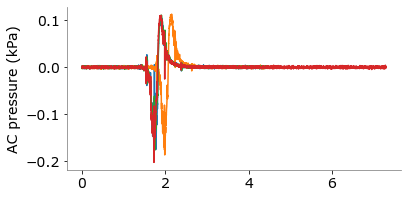

L110F1.5V002C0400D4000
Len=110, Infill=1.50, Condi: v=2 c=400 d=4000


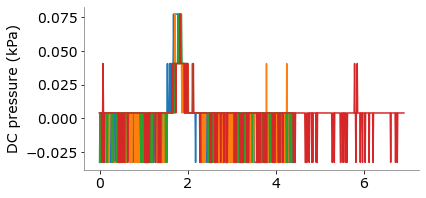

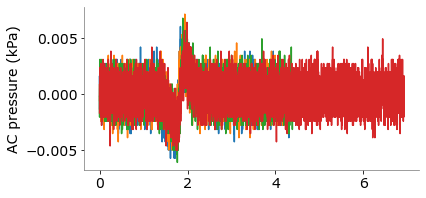

L110F1.5V035C0400D4000
Len=110, Infill=1.50, Condi: v=35 c=400 d=4000


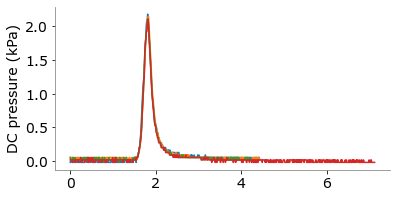

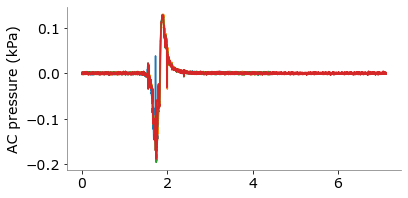

L110F1.5V050C0400D4000
Len=110, Infill=1.50, Condi: v=50 c=400 d=4000


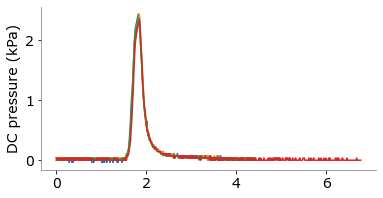

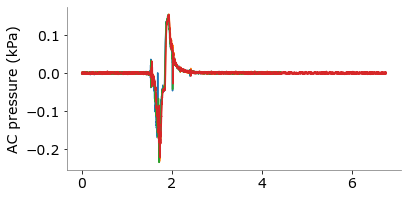

L110F1.5V005C0400D4000
Len=110, Infill=1.50, Condi: v=5 c=400 d=4000


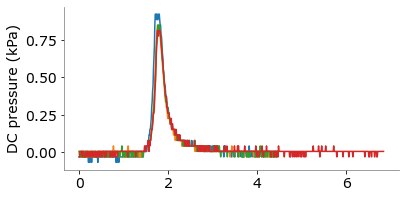

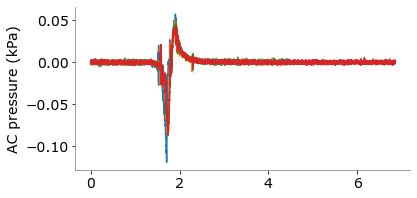

L110F1.5V075C0400D4000
Len=110, Infill=1.50, Condi: v=75 c=400 d=4000


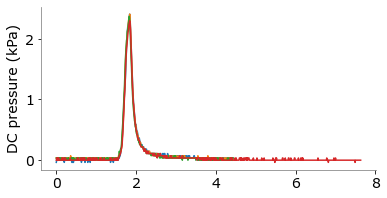

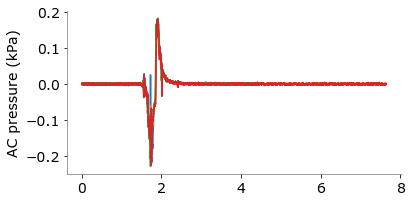

In [6]:
''' 
Signal check (optional, may be used for future when crosscorrelation of trials is desired)
'''
# for dLabel in allData['Label']:
for _, aRow in allData.iterrows():
    print(aRow['Label'])
    print("Len=%d, Infill=%.2f, Condi: v=%d c=%d d=%d" % 
                  (aRow['TubeLength_mm'], aRow['Infill_mL'], aRow['Voltage_V'], 
                   aRow['ChargeTime_ms'], aRow['DischargeTime_ms']))     
    
    ax0,_ = aPlot()
    for aSignal in aRow['Pdc']:
        t = aSignal[:,0] - aSignal[0,0]
        ax0.plot(t, aSignal[:,1])
    ax0.set_ylabel("DC pressure (kPa)")
    
    ax1,_ = aPlot()
    for aSignal in aRow['Pac']:
        t = aSignal[:,0] - aSignal[0,0]
        ax1.plot(t, aSignal[:,1])
    ax1.set_ylabel("AC pressure (kPa)")
    
    plt.show();


In [ ]:
'''Result Visualization: Voltage level with 1 sec charge time '''

compListA = ['L070F1.5V001C1000D4000','L070F1.5V002C1000D4000','L070F1.5V005C1000D4000','L070F1.5V015C1000D4000',
            'L070F1.5V050C1000D4000','L070F1.5V100C1000D4000']
compListB = ['L110F1.5V001C1000D4000','L110F1.5V002C1000D4000','L110F1.5V005C1000D4000','L110F1.5V015C1000D4000',
            'L110F1.5V050C1000D4000','L110F1.5V100C1000D4000']

''' Comp. List A '''
indList = selectConditions(allData, compListA)

xLabelStr = allData.loc[indList,'Voltage_V'].values.astype('int')
x = np.arange(len(xLabelStr)) * 3

''' Prepare errorbar data for  List A '''
meanPeakPdc, stdPeakPdc = computeErrorbar(allData, indList, 'PeakPdc')
meanAvgPdc, stdAvgPdc = computeErrorbar(allData, indList, 'AvgPdc')
meanTrisePdc, stdTrisePdc = computeErrorbar(allData, indList, 'TrisePdc')

''' Comp. List B '''
indList2 = selectConditions(allData, compListB)
''' Prepare errorbar data for List B '''
meanPeakPdc2, stdPeakPdc2 = computeErrorbar(allData, indList2, 'PeakPdc')
meanAvgPdc2, stdAvgPdc2 = computeErrorbar(allData, indList2, 'AvgPdc')
meanTrisePdc2, stdTrisePdc2 = computeErrorbar(allData, indList2, 'TrisePdc')

 
''' Plot of peak pressure '''
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Peak Pressure (kPa)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanPeakPdc, yerr=stdPeakPdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Voltage (%)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);

pH2 = ax1.bar(x+1, meanPeakPdc2, yerr=stdPeakPdc2, align='center', alpha=1.0, ecolor='black', color='tab:orange')

ax1.legend(handles=[pH1[0],pH2[0]], labels=['70 mm','110 mm'],
           frameon=False, bbox_to_anchor=(1.02, 1.0), loc='upper left');

plt.savefig("CompVoltage_Peak.pdf", bbox_inches='tight')


''' Plot of t-avg pressure ''' 
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Avg. Pressure (kPa)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanAvgPdc, yerr=stdAvgPdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Voltage (%)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);

pH2 = ax1.bar(x+1, meanAvgPdc2, yerr=stdAvgPdc2, align='center', alpha=1.0, ecolor='black', color='tab:orange')

ax1.legend(handles=[pH1[0],pH2[0]], labels=['70 mm','110 mm'],
           frameon=False, bbox_to_anchor=(1.02, 1.0), loc='upper left');

# plt.savefig("CompVoltage_Avg.pdf", bbox_inches='tight')

''' Plot of rise time '''
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Rise Time (sec)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanTrisePdc, yerr=stdTrisePdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Voltage (%)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);
            
pH2 = ax1.bar(x+1, meanTrisePdc2, yerr=stdTrisePdc2, align='center', alpha=1.0, ecolor='black', color='tab:orange')

ax1.legend(handles=[pH1[0],pH2[0]], labels=['70 mm','110 mm'],
           frameon=False, bbox_to_anchor=(1.02, 1.0), loc='upper left');

# plt.savefig("CompVoltage_RiseT.pdf", bbox_inches='tight')

# # # May not need boxplot
# boxprops = dict(linestyle='-', linewidth=1, color='w', facecolor='0.85')
# medianprops = dict(linestyle='-', linewidth=3, color='tab:orange')
# pH1 = ax1.boxplot(compPeakPdc, positions=x, widths = 0.15, manage_ticks = False, medianprops=medianprops,
#                  patch_artist=True, boxprops=boxprops, notch = False, showfliers = True)"

In [ ]:
'''Result Visualization: Charge time'''

compListA = ['L110F1.5V100C0100D4000','L110F1.5V100C0200D4000','L110F1.5V100C0400D4000','L110F1.5V100C0700D4000',
             'L110F1.5V100C1000D4000']
compListB = ['L070F1.5V100C0100D4000','L070F1.5V100C0200D4000','L070F1.5V100C0400D4000',
             'L070F1.5V100C0700D4000','L070F1.5V100C1000D4000'] #'L070F1.5V100C0050D4000'

''' Comp. List A '''
indList = selectConditions(allData, compListA)

xLabelStr = allData.loc[indList,'ChargeTime_ms'].values.astype('int') / 1000
x = np.arange(len(xLabelStr)) * 3

''' Prepare errorbar data for  List A '''
meanPeakPdc, stdPeakPdc = computeErrorbar(allData, indList, 'PeakPdc')
meanAvgPdc, stdAvgPdc = computeErrorbar(allData, indList, 'AvgPdc')
meanTrisePdc, stdTrisePdc = computeErrorbar(allData, indList, 'TrisePdc')

''' Comp. List B '''
indList2 = selectConditions(allData, compListB)
''' Prepare errorbar data for List B '''
meanPeakPdc2, stdPeakPdc2 = computeErrorbar(allData, indList2, 'PeakPdc')
meanAvgPdc2, stdAvgPdc2 = computeErrorbar(allData, indList2, 'AvgPdc')
meanTrisePdc2, stdTrisePdc2 = computeErrorbar(allData, indList2, 'TrisePdc')

''' Plot of peak pressure '''
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Peak Pressure (kPa)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanPeakPdc, yerr=stdPeakPdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Charge Time (sec)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);

pH2 = ax1.bar(x+1, meanPeakPdc2, yerr=stdPeakPdc2, align='center', alpha=1.0, ecolor='black', color='tab:orange')

ax1.legend(handles=[pH1[0],pH2[0]], labels=['70 mm','110 mm'], 
           frameon=False, bbox_to_anchor=(1.02, 1.0), loc='upper left');

# plt.savefig("CompCtime_Peak.pdf", bbox_inches='tight')

''' Plot of t-avg pressure '''
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Avg. Pressure (kPa)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanAvgPdc, yerr=stdAvgPdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Charge Time (sec)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);

pH2 = ax1.bar(x+1, meanAvgPdc2, yerr=stdAvgPdc2, align='center', alpha=1.0, ecolor='black', color='tab:orange')

ax1.legend(handles=[pH1[0],pH2[0]], labels=['70 mm','110 mm'],
           frameon=False, bbox_to_anchor=(1.02, 1.0), loc='upper left');

# plt.savefig("CompCtime_Avg.pdf", bbox_inches='tight')

''' Plot of rise time '''
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Rise Time (sec)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanTrisePdc, yerr=stdTrisePdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Charge Time (sec)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);

pH2 = ax1.bar(x+1, meanTrisePdc2, yerr=stdTrisePdc2, align='center', alpha=1.0, ecolor='black', color='tab:orange')

ax1.legend(handles=[pH1[0],pH2[0]], labels=['70 mm','110 mm'],
           frameon=False, bbox_to_anchor=(1.02, 1.0), loc='upper left');

# plt.savefig("CompCtime_RiseT.pdf", bbox_inches='tight')

<ipython-input-9-c3de3a058ff2>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xLabelStr, rotation=0);


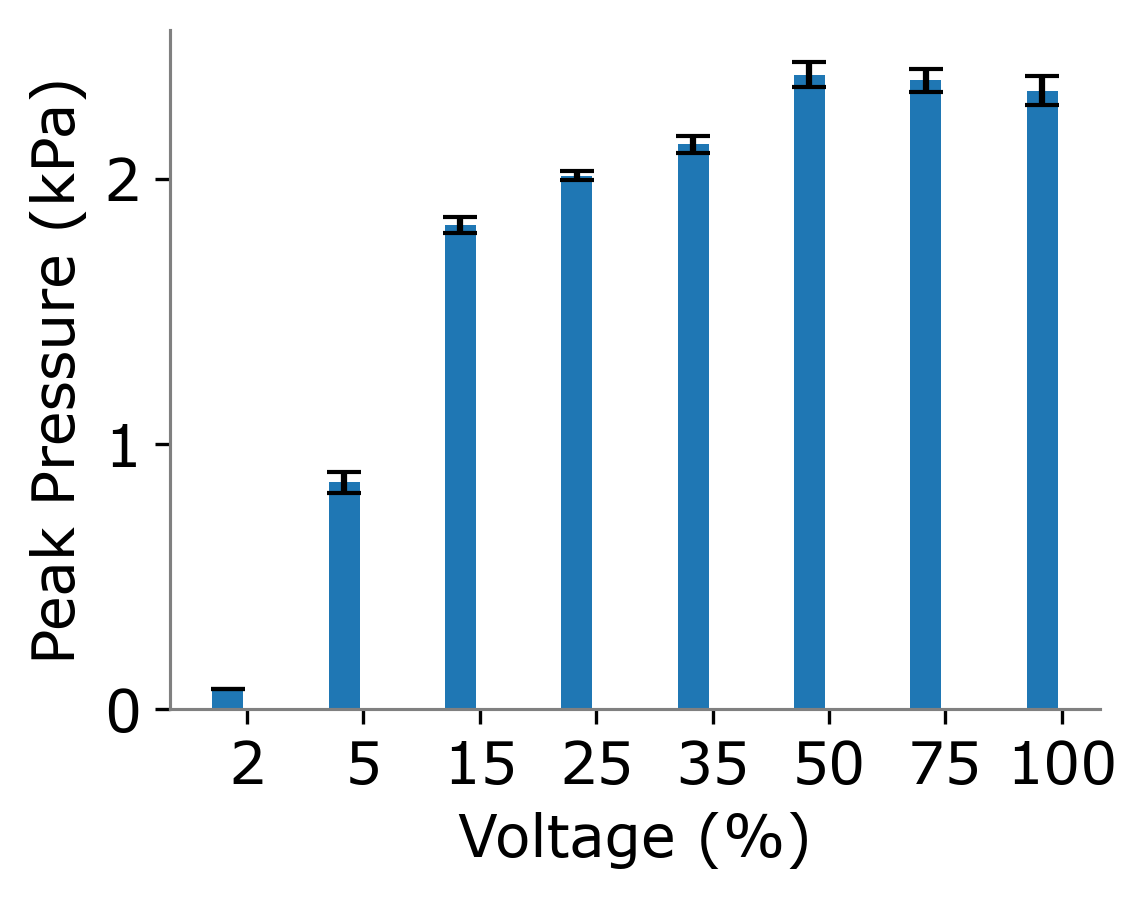

In [9]:
''' Quick Test Result: Voltage level with 400 ms charge time '''
compListA = ['L110F1.5V002C0400D4000','L110F1.5V005C0400D4000','L110F1.5V015C0400D4000','L110F1.5V025C0400D4000',
   'L110F1.5V035C0400D4000','L110F1.5V050C0400D4000','L110F1.5V075C0400D4000','L110F1.5V100C0400D4000']

''' Comp. List A '''
indList = selectConditions(allData, compListA)

xLabelStr = allData.loc[indList,'Voltage_V'].values.astype('int')
x = np.arange(len(xLabelStr)) * 3

''' Prepare errorbar data for  List A '''
meanPeakPdc, stdPeakPdc = computeErrorbar(allData, indList, 'PeakPdc')
meanAvgPdc, stdAvgPdc = computeErrorbar(allData, indList, 'AvgPdc')
meanTrisePdc, stdTrisePdc = computeErrorbar(allData, indList, 'TrisePdc')

 
''' Plot of peak pressure '''
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(4,3)

ax1.set_ylabel('Peak Pressure (kPa)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

pH1 = ax1.bar(x, meanPeakPdc, yerr=stdPeakPdc, align='center', alpha=1.0, ecolor='black', color='tab:blue')
ax1.set_xlabel('Voltage (%)')
ax1.set_xticklabels(xLabelStr, rotation=0);
plt.xticks(x+0.5);
